<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Scenario-1:-Grid-flow-imputation" data-toc-modified-id="Scenario-1:-Grid-flow-imputation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Scenario 1: Grid-flow imputation</a></span><ul class="toc-item"><li><span><a href="#Evaluation-metrics" data-toc-modified-id="Evaluation-metrics-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Evaluation metrics</a></span></li><li><span><a href="#Load-the-dataset" data-toc-modified-id="Load-the-dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Load the dataset</a></span><ul class="toc-item"><li><span><a href="#aggregate-128-$\times$-128-to-64-$\times$-64" data-toc-modified-id="aggregate-128-$\times$-128-to-64-$\times$-64-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>aggregate 128 $\times$ 128 to 64 $\times$ 64</a></span></li></ul></li><li><span><a href="#Define-the-model" data-toc-modified-id="Define-the-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Define the model</a></span></li><li><span><a href="#Scenario-1:-estimating-at-different-resolutions" data-toc-modified-id="Scenario-1:-estimating-at-different-resolutions-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Scenario 1: estimating at different resolutions</a></span><ul class="toc-item"><li><span><a href="#model-training" data-toc-modified-id="model-training-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>model training</a></span></li></ul></li></ul></li><li><span><a href="#Scenario-2:-OD-flow-imputation" data-toc-modified-id="Scenario-2:-OD-flow-imputation-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Scenario 2: OD flow imputation</a></span><ul class="toc-item"><li><span><a href="#Load-the-dataset" data-toc-modified-id="Load-the-dataset-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Load the dataset</a></span></li><li><span><a href="#Model-training" data-toc-modified-id="Model-training-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Model training</a></span></li></ul></li></ul></div>

**In this notebook, we will develop a ST-INR model from scratch in the gird-based flow estimation/imputation task.**  In this task, the input data is structured in a 3-D tensor. Therefore, we release a 3D implementation to adapt for this case.
We consider two kinds of scenarios:

- Urban grid-based taxi trip flows;
- Urban origin-destination (OD) flows.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['font.family'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42

from torch import nn, optim 
import numpy as np 
import scipy.io
from typing import Optional,List
import torch
import math
from torch import Tensor
import torch.nn.functional as F

dtype = torch.cuda.FloatTensor

## Scenario 1: Grid-flow imputation

### Evaluation metrics

In [2]:
def compute_mape(var, var_hat):
    return np.sum(np.abs(var - var_hat) / var) / var.shape[0]

def compute_wmape(var, var_hat):
    return np.sum(np.abs(var - var_hat)) / np.sum(var)

def compute_rmse(var, var_hat):
    return np.sqrt(np.sum((var - var_hat) ** 2) / var.shape[0])

### Load the dataset

(336, 32, 32) (336, 128, 128)


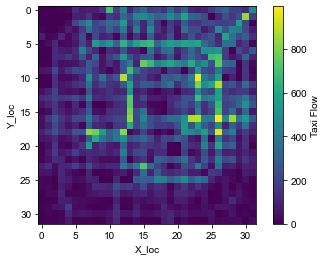

In [3]:
dense_tensor_32 = np.load('datasets/TaxiBJ/dense_tensor_32.npy')
dense_tensor_128 = np.load('datasets/TaxiBJ/dense_tensor_128.npy')

print(dense_tensor_32.shape, dense_tensor_128.shape)
plt.imshow(dense_tensor_32[28])
plt.xlabel('X_loc')
plt.ylabel('Y_loc')
plt.colorbar(label='Taxi Flow')

#### aggregate 128 $\times$ 128 to 64 $\times$ 64

In [4]:
dense_tensor_64 = np.zeros((dense_tensor_128.shape[0],64, 64))
for T in range(dense_tensor_128.shape[0]):
    data_bj_y_128 = dense_tensor_128[T]
    downsampling_factor = 2
    data_bj_y_64 = np.zeros((64, 64))
    for i in range(64):
        for j in range(64):
            window = data_bj_y_128[2*i:2*(i+1), 2*j:2*(j+1)]  
            data_bj_y_64[i, j] = np.sum(window)  
    dense_tensor_64[T] = data_bj_y_64

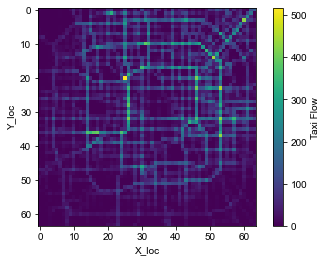

In [5]:
plt.imshow(dense_tensor_64[28])
plt.xlabel('X_loc')
plt.ylabel('Y_loc')
plt.colorbar(label='Taxi Flow')

### Define the model

In [6]:
class ST_INR3d(nn.Module):
    def __init__(self, r_1,r_2, r_3, mid_channel,n_inr_layers,n_fourier_feats,scales, omega):
        super(ST_INR3d, self).__init__()
        
        self.U_net = MixINR(1,n_inr_layers, mid_channel,r_1, n_fourier_feats,scales, omega)
        self.V_net = MixINR(1,n_inr_layers, mid_channel,r_2, n_fourier_feats,scales, omega)
        self.W_net = MixINR(1,n_inr_layers, mid_channel,r_3, n_fourier_feats,scales, omega)
        

    def forward(self, centre, U_input, V_input, W_input):
        """
        centre: (r_1,r_2, r_3)
        """
        U = self.U_net(U_input)
        V = self.V_net(V_input)
        W = self.W_net(W_input)
        
        centre = centre.permute(1,2,0) 
        centre = centre @ U.t()
        centre = centre.permute(2,1,0) 
        centre = centre @ V.t()
        centre = centre.permute(0,2,1) 
        centre = centre @ W.t()
        
        return centre
    
    
class GaussianFourierFeatureTransform(nn.Module):
    """
    Given an input of size [..., time, dim], returns a tensor of size [..., time,n_fourier_feats].
    """
    def __init__(self, input_dim: int, n_fourier_feats: int, scales: List[int]):
        super().__init__()
        self.input_dim = input_dim
        self.n_fourier_feats = n_fourier_feats
        self.scales = scales

        n_scale_feats = n_fourier_feats // (2 * len(scales))
        assert n_scale_feats * 2 * len(scales) == n_fourier_feats, \
            f"n_fourier_feats: {n_fourier_feats} must be divisible by 2 * len(scales) = {2 * len(scales)}"
        B_size = (input_dim, n_scale_feats)
        B = torch.cat([torch.randn(B_size) * scale for scale in scales], dim=1)
        self.register_buffer('B', B)

    def forward(self, x: Tensor) -> Tensor:
        assert x.dim() >= 2, f"Expected 2 or more dimensional input (got {x.dim()}D input)"
        time, dim = x.shape[-2], x.shape[-1]

        assert dim == self.input_dim, \
            f"Expected input to have {self.input_dim} channels (got {dim} channels)"

        x = torch.einsum('... t n, n d -> ... t d', [x, self.B])
        x = 2 * math.pi * x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)
    
    
class MixINR(nn.Module):
    def __init__(self, in_feats: int, layers: int, layer_size: int, out_size: int, n_fourier_feats: int, scales: float,
                 omega, dropout: Optional[float] = 0.1):
        super().__init__()
        self.features =  GaussianFourierFeatureTransform(in_feats, n_fourier_feats, scales)
        in_size = n_fourier_feats
        layers = [MLP(in_size, layer_size, dropout=dropout)] + \
                 [SineLayer(layer_size, layer_size, omega) for _ in range(layers - 1)] + \
                 [SineLayer(layer_size, out_size, omega)]
        self.layers = nn.Sequential(*layers)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        return self.layers(x)
    
class MLP(nn.Module):
    def __init__(self, input_size: int, output_size: int,
                 dropout: Optional[float] = 0.1):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.linear = nn.Linear(input_size, output_size)
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(output_size)

    def forward(self, x: Tensor) -> Tensor:
        out = self._layer(x)
        return self.norm(out)

    def _layer(self, x: Tensor) -> Tensor:
        return self.dropout(torch.sin(self.linear(x)))
    

class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, omega_0, bias=True,
                 is_first=False): 
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

### Scenario 1: estimating at different resolutions

In [7]:
################### 
# hyperparameters. 
w_decay = 1  
lr_real = 0.0001
max_iter = 12000
omega = 10 
n_fourier_feats = 2048 
mid_channel = 512 
scales = [0.01, 0.1, 1, 5, 10, 20, 50, 100]
n_inr_layers = 2 
###################
dense_tensor = dense_tensor_64.copy()
# dense_tensor = dense_tensor_32.copy()
dim = dense_tensor.shape
missing_rate = 0.8 
np.random.seed(42)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)

X = torch.from_numpy(sparse_tensor).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
[n_1,n_2,n_3] = X.shape

r_1 = min(n_1,n_2,n_3)
r_2 = min(n_1,n_2,n_3)
r_3 = min(n_1,n_2,n_3) 

mask = np.ones(X.shape)
mask[(dense_tensor != 0) & (sparse_tensor == 0)] = 0 
mask = torch.from_numpy(mask).type(dtype).cuda()

#### model training

In [8]:
centre = torch.Tensor(r_1,r_2, r_3).type(dtype)
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)
U_input = torch.from_numpy(np.array(range(1,n_1+1))).reshape(n_1,1).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)
W_input = torch.from_numpy(np.array(range(1,n_3+1))).reshape(n_3,1).type(dtype)

model = ST_INR3d(r_1,r_2,r_3, mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr_real, weight_decay=w_decay) 

import time
start = time.time()

loss_record = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input, W_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 31 seconds.


Text(0.5, 0, 'steps')

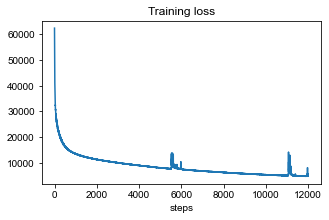

In [9]:
plt.subplots(figsize=(5,3))
plt.plot(loss_record)
plt.title('Training loss')
plt.xlabel('steps')

WAPE: 0.176593
RMSE: 21.8246


(-0.5, 63.5, 63.5, -0.5)

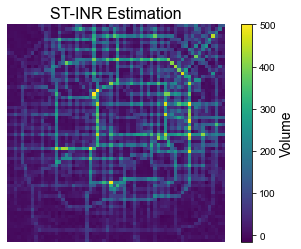

In [10]:
tensor_hat_inr = X_Out.cpu().detach().numpy()

ind = sparse_tensor != 0
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
print('WAPE: {:.6}'.format(compute_wmape(dense_tensor[pos_test], 
                                                    tensor_hat_inr[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], 
                                        tensor_hat_inr[pos_test])))

plt.imshow(tensor_hat_inr[10],vmax=500)
plt.title('ST-INR Estimation',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Volume',fontsize=14)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

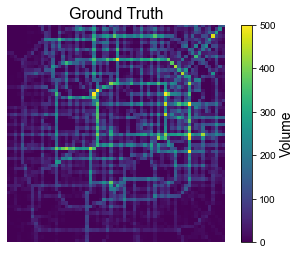

In [11]:
plt.imshow(dense_tensor[10],vmax=500)
plt.title('Ground Truth',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Volume',fontsize=14)
plt.axis('off')

(-0.5, 63.5, 63.5, -0.5)

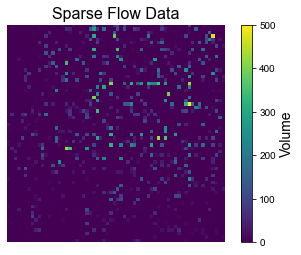

In [12]:
plt.imshow(sparse_tensor[10],vmax=500)
plt.title('Sparse Flow Data',fontsize=16)
cbar = plt.colorbar()
cbar.set_label('Volume',fontsize=14)
plt.axis('off')

## Scenario 2: OD flow imputation

### Load the dataset

In [13]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

path = 'datasets/NYC-taxi/'
tensor = np.load(path+'yellow_taxi_trip_2020.npz')['arr_0']
manhattan = np.array([127, 128, 153, 120, 243, 244, 116, 42, 152, 166, 41, 74, 194, 24, 151,
                      238, 75, 239, 43, 236, 263, 143, 142, 262, 50, 237, 141, 140, 202, 163,
                      48, 230, 161, 162, 229, 246, 100, 68, 186, 233, 164, 170, 90, 234, 137,
                      158, 249, 107, 113, 224, 114, 125, 79, 211, 4, 144, 231, 148, 232, 13,
                      261, 45, 209, 87, 12, 88, 105, 104, 103])
dense_tensor = tensor[:,:,:151]
dense_tensor.shape

(69, 69, 151)

C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is depr

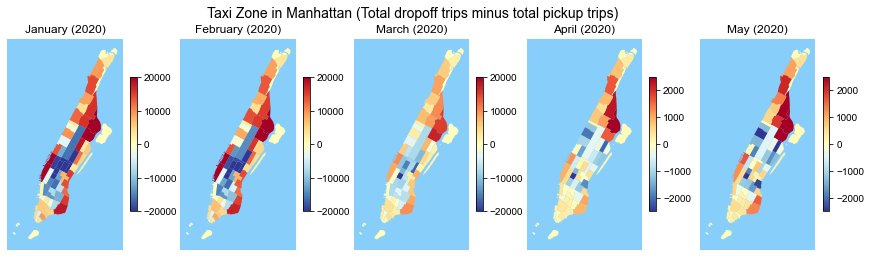

In [14]:
plt.rcParams['font.size'] = 10
fig = plt.figure(figsize = (15, 4))
plt.suptitle('Taxi Zone in Manhattan (Total dropoff trips minus total pickup trips)', fontsize=14)
for r in range(5):
    ax = fig.add_subplot(1, 5, r + 1)
    if r == 0:
        vec = np.sum(np.sum(dense_tensor[:, :, 0 : 31], axis = 2), axis = 0) - np.sum(np.sum(dense_tensor[:, :, 0 : 31], axis = 2), axis = 1)
    elif r == 1:
        vec = np.sum(np.sum(dense_tensor[:, :, 31 : 59], axis = 2), axis = 0) - np.sum(np.sum(dense_tensor[:, :, 31 : 59], axis = 2), axis = 1)
    elif r == 2:
        vec = np.sum(np.sum(dense_tensor[:, :, 59 : 90], axis = 2), axis = 0) - np.sum(np.sum(dense_tensor[:, :, 59 : 90], axis = 2), axis = 1)
    elif r == 3:
        vec = np.sum(np.sum(dense_tensor[:, :, 90 : 120], axis = 2), axis = 0) - np.sum(np.sum(dense_tensor[:, :, 90 : 120], axis = 2), axis = 1)
    elif r == 4:
        vec = np.sum(np.sum(dense_tensor[:, :, 120 : 151], axis = 2), axis = 0) - np.sum(np.sum(dense_tensor[:, :, 120 : 151], axis = 2), axis = 1)
    manhattan[np.where(vec == vec.max())[0]][0]
    data = {'OBJECTID': manhattan, 'count': vec}

    shape = gpd.read_file(path+"taxi_zones.shp")
    Manhattan = shape[shape.borough == 'Manhattan']
    df = pd.DataFrame(data)
    merged = Manhattan.set_index('OBJECTID').join(df.set_index('OBJECTID'))
    merged = merged.reset_index()

    if r == 0 or r == 1:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -20000, vmax = 20000, ax = ax)
    if r == 2:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -20000, vmax = 20000, ax = ax)
    if r == 3:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -2500, vmax = 2500, ax = ax)
    if r == 4:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -2500, vmax = 2500, ax = ax)
    plt.xticks([])
    plt.yticks([])
    if r == 0:
        plt.title('January (2020)')
    elif r == 1:
        plt.title('February (2020)')
    elif r == 2:
        plt.title('March (2020)')
    elif r == 3:
        plt.title('April (2020)')
    elif r == 4:
        plt.title('May (2020)')
    for _, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_facecolor('lightskyblue')

### Model training

In [15]:
################### 
# Hyperparameters. 
w_decay = 1  
lr_real = 0.0001
max_iter = 10000
omega = 10 
n_fourier_feats = 2048 
scales = [0.01, 0.1, 1, 5, 10, 20, 50, 100]
n_inr_layers = 2 
mid_channel = 512 
###################

dim = dense_tensor.shape
missing_rate = 0.6 
np.random.seed(42)
sparse_tensor = dense_tensor * np.round(np.random.rand(dim[0], dim[1], dim[2]) + 0.5 - missing_rate)

X = torch.from_numpy(sparse_tensor).type(dtype).cuda()
X = torch.where(torch.isnan(X), 0, X)
[n_1,n_2,n_3] = X.shape


r_1 = min(n_1,n_2,n_3)
r_2 = min(n_1,n_2,n_3)
r_3 = min(n_1,n_2,n_3) 

mask = np.ones(X.shape)
mask[(dense_tensor != 0) & (sparse_tensor == 0)] = 0 
mask = torch.from_numpy(mask).type(dtype).cuda()

In [16]:
centre = torch.Tensor(r_1,r_2, r_3).type(dtype)
stdv = 1 / math.sqrt(centre.size(0))
centre.data.uniform_(-stdv, stdv)
U_input = torch.from_numpy(np.array(range(1,n_1+1))).reshape(n_1,1).type(dtype)
V_input = torch.from_numpy(np.array(range(1,n_2+1))).reshape(n_2,1).type(dtype)
W_input = torch.from_numpy(np.array(range(1,n_3+1))).reshape(n_3,1).type(dtype)

model = ST_INR3d(r_1,r_2,r_3, mid_channel,n_inr_layers,n_fourier_feats,scales,omega).type(dtype)
params = []
params += [x for x in model.parameters()]
centre.requires_grad=True
params += [centre]
optimizier = optim.Adam(params, lr=lr_real, weight_decay=w_decay) 

import time
start = time.time()

loss_record = []
for iter in range(max_iter):
    X_Out = model(centre, U_input, V_input, W_input)
    loss = torch.norm(X_Out*mask-X*mask,2)
    optimizier.zero_grad()
    loss.backward(retain_graph=True)
    optimizier.step()
    loss_record.append(loss.detach().cpu().numpy())
    
end = time.time()
print('Running time: %d seconds.'%(end - start))

Running time: 24 seconds.


Text(0.5, 0, 'steps')

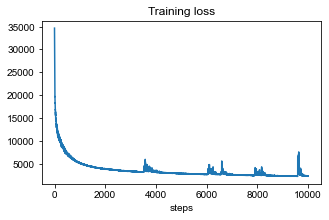

In [17]:
plt.subplots(figsize=(5,3))
plt.plot(loss_record)
plt.title('Training loss')
plt.xlabel('steps')

In [18]:
tensor_hat_inr = X_Out.cpu().detach().numpy()
pos_test = np.where((dense_tensor != 0) & (sparse_tensor == 0))
print('WAPE: {:.6}'.format(compute_wmape(dense_tensor[pos_test], 
                                                    tensor_hat_inr[pos_test])))
print('RMSE: {:.6}'.format(compute_rmse(dense_tensor[pos_test], 
                                        tensor_hat_inr[pos_test])))

WAPE: 0.145017
RMSE: 8.77558


C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
C:\ProgramData\Anaconda3\lib\site-packages\geopandas\plotting.py:51: ShapelyDeprecationWarning: The 'type' attribute is depr

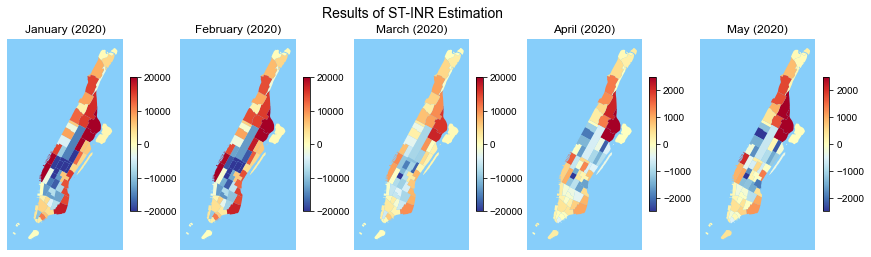

In [19]:
plt.rcParams['font.size'] = 10
fig = plt.figure(figsize = (15, 4))
plt.suptitle('Results of ST-INR Estimation', fontsize=14)
for r in range(5):
    ax = fig.add_subplot(1, 5, r + 1)
    if r == 0:
        vec = np.sum(np.sum(tensor_hat_inr[:, :, 0 : 31], axis = 2), axis = 0) - np.sum(np.sum(tensor_hat_inr[:, :, 0 : 31], axis = 2), axis = 1)
    elif r == 1:
        vec = np.sum(np.sum(tensor_hat_inr[:, :, 31 : 59], axis = 2), axis = 0) - np.sum(np.sum(tensor_hat_inr[:, :, 31 : 59], axis = 2), axis = 1)
    elif r == 2:
        vec = np.sum(np.sum(tensor_hat_inr[:, :, 59 : 90], axis = 2), axis = 0) - np.sum(np.sum(tensor_hat_inr[:, :, 59 : 90], axis = 2), axis = 1)
    elif r == 3:
        vec = np.sum(np.sum(tensor_hat_inr[:, :, 90 : 120], axis = 2), axis = 0) - np.sum(np.sum(tensor_hat_inr[:, :, 90 : 120], axis = 2), axis = 1)
    elif r == 4:
        vec = np.sum(np.sum(tensor_hat_inr[:, :, 120 : 151], axis = 2), axis = 0) - np.sum(np.sum(tensor_hat_inr[:, :, 120 : 151], axis = 2), axis = 1)
    manhattan[np.where(vec == vec.max())[0]][0]
    data = {'OBJECTID': manhattan, 'count': vec}

    shape = gpd.read_file(path+"taxi_zones.shp")
    Manhattan = shape[shape.borough == 'Manhattan']
    df = pd.DataFrame(data)
    merged = Manhattan.set_index('OBJECTID').join(df.set_index('OBJECTID'))
    merged = merged.reset_index()

    if r == 0 or r == 1:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -20000, vmax = 20000, ax = ax)
    if r == 2:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -20000, vmax = 20000, ax = ax)
    if r == 3:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -2500, vmax = 2500, ax = ax)
    if r == 4:
        merged.plot('count', cmap = 'RdYlBu_r',
                    legend = True, legend_kwds = {'shrink': 0.618},
                    vmin = -2500, vmax = 2500, ax = ax)
    plt.xticks([])
    plt.yticks([])
    if r == 0:
        plt.title('January (2020)')
    elif r == 1:
        plt.title('February (2020)')
    elif r == 2:
        plt.title('March (2020)')
    elif r == 3:
        plt.title('April (2020)')
    elif r == 4:
        plt.title('May (2020)')
    for _, spine in ax.spines.items():
        spine.set_visible(False)
    ax.set_facecolor('lightskyblue')